In [821]:
import pandas as pd
import numpy as np
import itertools
from collections import Counter
from datetime import datetime
import re
import ast

from pandas_profiling import ProfileReport

import my_functions
import importlib
importlib.reload(my_functions)

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from scipy import stats


In [822]:
input_folder = 'input\\'
print(os.listdir("input"))


['main_task.csv']


In [823]:
RANDOM_SEED = 123

# DATA
## Первоначальная версия датасета состоит из десяти столбцов, содержащих следующую информацию:
* Restaurant_id — идентификационный номер ресторана / сети ресторанов;
* City — город, в котором находится ресторан;
* Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
* Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
* Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
* Price Range — диапазон цен в ресторане;
* Number of Reviews — количество отзывов о ресторане;
* Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
* URL_TA — URL страницы ресторана на TripAdvosor;
* ID_TA — идентификатор ресторана в базе данных TripAdvisor.

In [824]:
data = pd.read_csv(input_folder + 'main_task.csv')
data.columns = data.columns.str.lower()
data.columns = [name.replace(' ', '_') for name in data.columns]
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      40000 non-null  object 
 1   city               40000 non-null  object 
 2   cuisine_style      30717 non-null  object 
 3   ranking            40000 non-null  float64
 4   rating             40000 non-null  float64
 5   price_range        26114 non-null  object 
 6   number_of_reviews  37457 non-null  float64
 7   reviews            40000 non-null  object 
 8   url_ta             40000 non-null  object 
 9   id_ta              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


# Обработка NaN

In [825]:
data['cuisine_style'] = data['cuisine_style'].fillna('[\'not_specified\']')

data['Number_of_Reviews_isNAN'] = pd.isna(data.number_of_reviews).astype('uint8')
data['number_of_reviews'] = data.groupby(by='city').number_of_reviews.apply(lambda x: x.fillna(round(x.mean())))
data['price_range'].fillna(data.price_range.mode()[0], inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   restaurant_id            40000 non-null  object 
 1   city                     40000 non-null  object 
 2   cuisine_style            40000 non-null  object 
 3   ranking                  40000 non-null  float64
 4   rating                   40000 non-null  float64
 5   price_range              40000 non-null  object 
 6   number_of_reviews        40000 non-null  float64
 7   reviews                  40000 non-null  object 
 8   url_ta                   40000 non-null  object 
 9   id_ta                    40000 non-null  object 
 10  Number_of_Reviews_isNAN  40000 non-null  uint8  
dtypes: float64(3), object(7), uint8(1)
memory usage: 3.1+ MB


# Предобработка

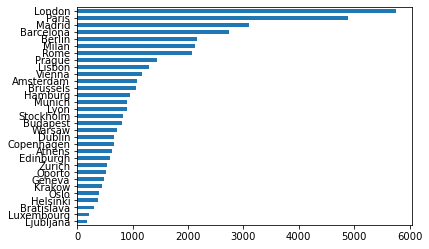

In [826]:
data.city.value_counts(ascending=True).plot(kind='barh')

In [827]:
data.drop(['restaurant_id', 'url_ta', 'id_ta'], inplace=True,  axis = 1, errors='ignore')
data['cuisine_style'] = data['cuisine_style'].apply(ast.literal_eval)
data['reviews'] = data['reviews'].apply(lambda x: re.sub((r'\bnan\b'), '\'empty_voice\'', x))
data['reviews'] = data['reviews'].apply(ast.literal_eval)

# Обогащаем новыми признаками 

In [828]:


data['reviews_text'] =  data['reviews'].apply(lambda x: x[0])
data['reviews_dates'] = data['reviews'].apply(lambda x: [datetime.strptime(date, '%m/%d/%Y').date() for date in x[1]])


set_dates = set()
data['dif_days'] = data.reviews_dates.apply(lambda x: (x[0] - x[-1]) if len(x) > 0 else pd.Timedelta('0 days') )
data['dif_days'] = data['dif_days'].dt.days
data['diff_today'] = data.reviews_dates.apply(my_functions.diff_today)
data['price_range_int'] = data.price_range.apply(lambda x: 1 if x == '$' else 
                                                              (2 if x == '$$ - $$$' else 3))

data['ranking_norm_by_city'] = data.groupby('city').ranking.transform(lambda x: (x - x.mean()) / x.std())


cuisine_style_set = set()
data.cuisine_style.apply(lambda x: cuisine_style_set.update(x))
cuisine_style_list = list(cuisine_style_set)
for cuisine in cuisine_style_list:
    data[cuisine] = data.cuisine_style.apply(lambda x: 1 if cuisine in x else 0)

data = pd.get_dummies(data, columns=['city'], dummy_na=True, drop_first=False)

In [829]:
# data['review_text_tone_coef'] = data['reviews_text'].apply(lambda x: my_functions.review_text_tone(x))

# # data['review_text_tone_coef'].value_counts()
# data['good_reviews'] = data.review_text_tone_coef.apply(lambda x: 1 if x > 1 else 0)
# data['bad_reviews'] = data.review_text_tone_coef.apply(lambda x: 1 if x < -1 else 0)




# datetime.today().date()

#data.iloc[:2].reviews_dates.apply(max)
# data[data.city == 'London'].ranking_mean_by_city

# EDA

In [830]:
# plt.rcParams['figure.figsize'] = (10,7)

# top10_city = data.city.value_counts()[0:10].index
# for city in top10_city:
#     data[data.city == city].ranking_mean_by_city.hist(bins=100)


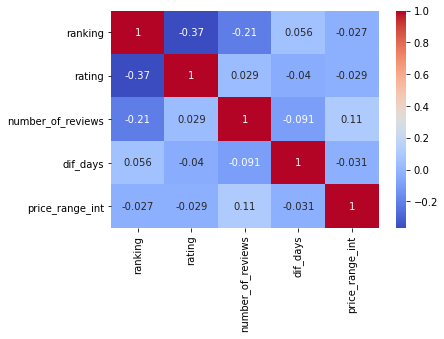

In [831]:


data.price_range.value_counts(dropna=False)

# data.groupby(by='city').agg({'price_range_int':'mean', 'city':'size'}).sort_values(by='price_range_int')
# data['price_range'] = data['price_range'].astype(str)
# data.groupby(by='price_range').agg({'city':lambda x: stats.mode(x) , 'ranking': 'mean', 'rating' : 'mean', 'number_of_reviews':'mean', 'dif_days':'mean'})

correlation = data[['ranking', 'rating', 'number_of_reviews', 'dif_days',
                    'price_range_int']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')

In [832]:
data[['price_range_int']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   price_range_int  40000 non-null  int64
dtypes: int64(1)
memory usage: 312.6 KB


In [833]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
from sklearn.linear_model import LinearRegression

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)

X = data.drop(['restaurant_id','city', 'rating', 'cuisine_style', 'price_range', 
               'reviews', 'url_ta', 'id_ta', 'reviews_text','reviews_dates',
               'review_text_tone_coef'], 
               axis = 1, errors='ignore')
y = data['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Создаём модель
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [834]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.210050625


MAE: 0.210050625  
MAE: 0.21450125  
0.21451624999999996  
MAE: 0.21875124999999998  
MAE: 0.2084305  
MAE: 0.210808  
0.2131725  
MAE: 0.2148355  
MAE: 0.21277599999999997  
MAE: 0.2086605   
MAE: 0.34141057440476186